В данном ноутбуке представлен код для препроцессинга данных из csv файла, обучения XGBoost-модели и предсказания зарплаты по вакансиям из тестового датасета.

Автор ноутбука: Кусакин Илья

In [22]:
import pandas as pd
import numpy as np
#reading csv file for train
dataframe = pd.read_csv("/content/drive/My Drive/labour_hackathon/vacs_train.csv" ,comment='#', sep=";")
#fixing random
np.random.seed(42)

In [ ]:
!pip install pymorphy2
#lemmatizer
import pymorphy2
pymorph = pymorphy2.MorphAnalyzer()

def my_lemming(word):
  return pymorph.parse(word)[0].normal_form
#stemmer
from nltk.stem.snowball import SnowballStemmer 
stemmer = SnowballStemmer("russian") 

import random
import nltk
import re
import gensim

wv_embeddings = gensim.models.KeyedVectors.load_word2vec_format(fname='/content/drive/My Drive/labour_hackathon/model.bin', binary=True)

from nltk.tokenize import WordPunctTokenizer
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords

tokenizer = WordPunctTokenizer()
stopWords = set(stopwords.words('russian'))
stopWords.add("'")
stopWords.add('\\')
from nltk.stem.snowball import SnowballStemmer

#убираем части речи через _ в русском словаре
my_embeddings = dict()
for i in wv_embeddings.vocab:
  without_ = re.sub('_\w+', '', i)
  my_embeddings[without_]=wv_embeddings[i]



In [3]:
def df_preproc(dataframe):
"""
Function for preprocessing columns, deleting nan-values 
and extracting new one-hot-encoded features of columns "shedule" and "employement"

returns: preprocessed dataframe
"""
    
    dataframe['name.lemm'] = dataframe['name.lemm'].fillna('unknown') 
    dataframe['company'] = dataframe['company'].fillna('unknown')
    dataframe['salary_from'] = np.array(dataframe['salary_from'].fillna('30000'), dtype=int)
    dataframe['employment.name'] = dataframe['employment.name'].fillna('Полная занятость')
    dataframe['schedule.name'] = dataframe['schedule.name'].fillna('Полный день')
    dataframe['experience.name'] = dataframe['experience.name'].fillna('От 1 года до 3 лет')
    dataframe['description.lemm'] = dataframe['description.lemm'].fillna('неизвестно')
    dataframe['specializations'] = dataframe['specializations'].fillna('0')

    exp = []
    for i in dataframe['experience.name']:
       if i=='Более 6 лет':
         exp.append(6)
       if i=='Нет опыта':
         exp.append(0)
       if i=='От 1 года до 3 лет':
         exp.append(2)
       if i=='От 3 до 6 лет':
         exp.append(4.5)
    dataframe['experience.name'] = exp
  
    dataframe['key_skills'] = dataframe['key_skills'].fillna('unknown')

    kek=np.array(dataframe["employment.name"], dtype=str)
    for i in np.unique(kek):
      dataframe[i] = [0]*len(dataframe['salary_from'])
    for i in range(len(dataframe['city'])):
      dataframe[dataframe['employment.name'][i]][i]=1
      
    kek=np.array(dataframe["schedule.name"], dtype=str)
    for i in np.unique(kek):
      dataframe[i] = [0]*len(dataframe['salary_from'])
    for i in range(len(dataframe['city'])):
      dataframe[dataframe['schedule.name'][i]][i]=1
    
    
    
    

    return dataframe

In [4]:
def skills_important(dataframe):
  """
    Function that checks 15 most frequent skills from vacancy.
    dataframe :  dataframe with vacancy

    Returns:
    Dataframe with 1 in columns of skills if it exists in vacancy.
    Zeroes if not exist.
  """

  skills_list =['команда',
    'коммуникация',
    'продажа',
    'программа',
    'способность',
    'объем',
    'информация',
    'автоматизация',
    'ведение',
    'переписка',
    'умение',
    'интернет',
    'планирование',
    'контроль',
    'обеспечение']

  for i in skills_list:
    dataframe[i] = np.array([0]*len(dataframe['description.lemm']))

  for i in range(len(dataframe['key_skills'])):
    text = dataframe['key_skills'][i]
    text = re.sub('[\d+\xad]', '', text)
    words = [my_lemming(word) for word in tokenizer.tokenize(re.sub('[-\’,·”–●•№~✅“=#—«|"‚».?!:;()*^&%+/]', ' ' , text.lower())) if word not in stopWords]
    try:
      for word in words:
        dataframe[word][i] = 1
    except KeyError:
      pass
  return dataframe

In [5]:
def text_to_onevec(text, embeddings=my_embeddings):
    """
    Function for text vectorizing
    
        text: some text for vectorizing
        embeddings: embeggings from FastText model
        
        returns: averaged representation of text
    """

    text = re.sub('[\t\n]', ' ', text.lower())
    text = re.sub('[\d+\xad]', '', text)
    words = [word for word in tokenizer.tokenize(re.sub('[-\’,·”–●•№~✅“=#—«"‚»|.?!:;()*^&%+/]', ' ' , text)) if word not in stopWords]
    #print(words)
    n_known = 0
    result = 0
    for word in words:
      flag_known=0
      if my_lemming(word) in embeddings:
             result+=embeddings[my_lemming(word)]
             flag_known += 1
      if flag_known==0 and stemmer.stem(word) in embeddings:
           result+=embeddings[stemmer.stem(word)]
           flag_known += 1
      if flag_known>0:
         n_known+=1
                    
    if n_known == 0:
      return np.array([0]*300)
    else:
      return result/n_known

In [6]:
def descrs(dataframe):
    """
    Function for description vectorizing:
        
        dataframe: dataframe with column of descriptions
        
        returns: dataframe with features 
        of vectorized descriontion representation
    """
    
    dataframe['description.lemm'] = dataframe['description.lemm'].fillna('unknown') 
    descrs_vec = []
    for i in dataframe['description.lemm']:
        descrs_vec.append(text_to_onevec(i))
    descrs_df = pd.DataFrame(descrs_vec)
    name_descrs=[]
    for i in range(1,301):
      name_descrs.append('descrs_vec_'+str(i))
    descrs_df.columns = name_descrs

    return pd.concat([dataframe, descrs_df], axis=1)

In [7]:
def companys(dataframe):
  """
    Function for company title vectorizing
    
        dataframe: dataframe with column of companys titles
        
        returns: dataframe with vectorized representation of company title
  """

  dataframe['company'] = dataframe['company'].fillna('unknown')
  company_vec = []
  for i in dataframe['company']:
      company_vec.append(text_to_onevec(i))
  company_df = pd.DataFrame(company_vec)
  name_company=[]
  for i in range(1,301):
    name_company.append('company_vec_'+str(i))
  company_df.columns = name_company
  
  return pd.concat([dataframe, company_df], axis=1)

In [8]:
def titles(dataframe):
  """
    Function for vacancy title vectorizing
    
    dataframe: dataframe with column of vacancy titles
    
    returns: dataframe with vectorized representation of vacancy titles
  """

  dataframe['name.lemm'] = dataframe['name.lemm'].fillna('unknown')
  title_vec = []
  for i in dataframe['name.lemm']:
      title_vec.append(text_to_onevec(i))
  title_df = pd.DataFrame(title_vec)
  name_title=[]
  for i in range(1,301):
    name_title.append('title_vec_'+str(i))
  title_df.columns = name_title
  
  return pd.concat([dataframe, title_df], axis=1)

Functions for data preprocessing and features creating are ready

In [ ]:
#preprocessing pipeline
dataframe= df_preproc(dataframe)
dataframe = companys(dataframe)
dataframe = titles(dataframe)
dataframe = skills_important(dataframe)

In [10]:
#deleting unused columns
dataframe = dataframe.drop(['index', 'id', 'name.lemm', 'name', 'area.name', 'city', 'company.id', 'company', 'company_link', 'publication_date',
                'employment', 'employment.name', 'schedule', 'schedule.name', 'experience', 
                'key_skills', 'specializations', 'specializations.names',
                'description', 'description.lemm', 'salary_currency', 'type'], axis=1)

Now we have clear dataset with new features created by one-hot-encoding and word vectorizing. Lets make some analysis about salaries. 

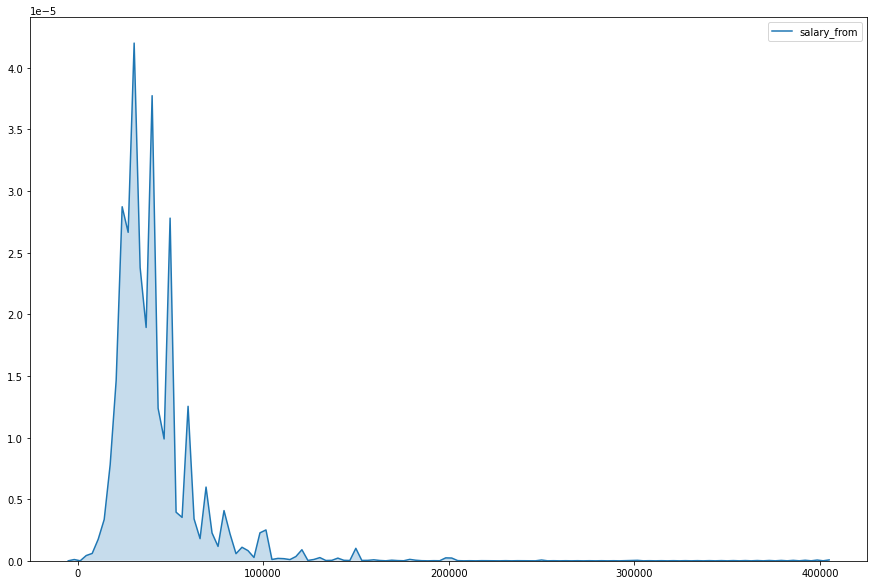

In [16]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

snsplot = sns.kdeplot(targets, shade=True, )
fig = snsplot.get_figure()
fig.set_size_inches(15, 10)

{'boxes': [<matplotlib.lines.Line2D at 0x7f41c9d32eb8>],
 'caps': [<matplotlib.lines.Line2D at 0x7f41c9d40908>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f41c9d4f3c8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f41c9d4f048>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f41c9d40208>,
  <matplotlib.lines.Line2D at 0x7f41c9d40588>]}

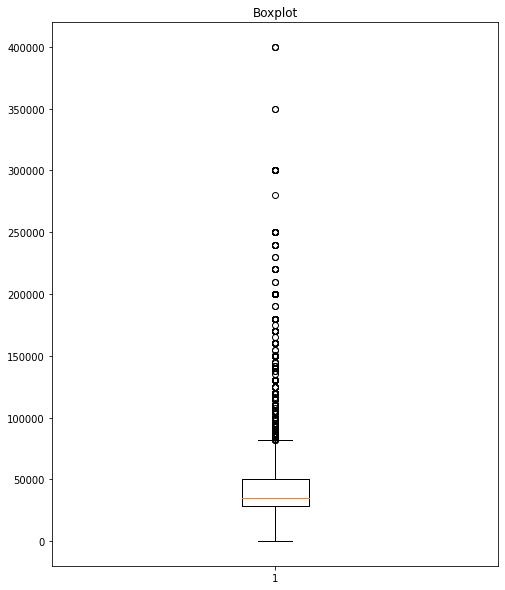

In [20]:
fig1, ax1 = plt.subplots(figsize=(8,10))
ax1.set_title('Boxplot')
ax1.boxplot(targets)

It is clearly seen, that the median salary is lower that 50k rubles, and third quartile is lower than 100k rubles. So we need to filter data before model training.

In [11]:
#filtering targets by crating bool array ok_salary
ok_salary = (dataframe['salary_from']<95000) & (dataframe['salary_from']>4000)
targets = dataframe['salary_from']
dataframe = dataframe.drop(['salary_from'], axis=1)

#file with vectorized descriptions from train dataset
descrs_df = pd.read_csv("/content/drive/My Drive/labour_hackathon/descrs_df1.csv",sep=";")

dataframe_np = np.array(dataframe)
descrs_np = np.array(descrs_df)

#np.array for training
full = np.concatenate((dataframe_np, descrs_np), axis=1)

Xgb-regressor trainiung

In [ ]:
#xgb-regressor
import xgboost as xgb
model = xgb.XGBRegressor()
#model fitting
model.fit(full[ok_salary],targets[ok_salary])

Saving trained model

In [47]:
import pickle
pickle.dump(model, open("/content/drive/My Drive/labour_hackathon/model_95sal_full.pickle.dat", "wb"))

Now we can use trained model for salary predicting

In [21]:
import pandas as pd
import numpy as np
#test dataset
dataframe_test = pd.read_csv("/content/drive/My Drive/labour_hackathon/vacs_test.csv" ,comment='#', sep=";")
np.random.seed(42)

In [ ]:
#preprocesing test data
dataframe= df_preproc(dataframe_test)
dataframe = companys(dataframe)
dataframe = titles(dataframe)
dataframe = skills_important(dataframe)

dataframe = dataframe.drop(['index', 'id', 'name.lemm', 'name', 'area.name', 'city', 'company.id', 'company', 'company_link', 'publication_date',
                'employment', 'employment.name', 'schedule', 'schedule.name', 'experience', 
                'key_skills', 'specializations', 'specializations.names',
                'description', 'description.lemm', 'salary_currency', 'type'], axis=1)

In [ ]:
dataframe = dataframe.drop(['salary_from'], axis=1)
descrs_df = pd.read_csv("/content/drive/My Drive/labour_hackathon/descrs_test.csv",sep=";")

dataframe_np = np.array(dataframe)
descrs_np = np.array(descrs_df)

full = np.concatenate((dataframe_np, descrs_np), axis=1)

In [ ]:
model =pickle.load(open("/content/drive/My Drive/labour_hackathon/model_95sal_full.pickle.dat", "rb"))

salary_test = model.predict(full)

Adding predicted salaries to test dataset and saving it

In [100]:
dataframe_test['salary_from'] = salary_test
dataframe_test.to_csv("/content/drive/My Drive/labour_hackathon/result_df.csv",sep=";", index=0)